# Vector Extraction (Causal Metric)

This notebook extracts steering vectors using the same method as notebook 02, but ranks layers by **causal norm** instead of Euclidean L2 norm.

**Key difference:** After extracting vectors in parameter space (Euclidean), we measure their semantic significance using the causal metric tensor M = Cov(γ)⁻¹.

**Hypothesis:** The causal norm `||v||_M = √(v^T M v)` reveals which layers encode semantically potent directions, potentially identifying different "best layers" than Euclidean magnitude.

**Method:** Same as notebook 02 (contrastive activation averaging with `output_hidden_states`), but:
1. Extract vectors in Euclidean space (unchanged)
2. Load causal metric tensor M
3. Compute both Euclidean and causal norms for each layer
4. Compare which layers rank highest by each metric

## Configuration

In [13]:
# Dataset configuration
DATASET_PATH = '../data/wikipedia_top20_texts.json'  # Path to JSON with text pairs
DATASET_NAME = 'wikipedia'  # Used for output file naming

# Model configuration
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'
MAX_SEQ_LENGTH = 4096  # Truncate texts to this many tokens

# Processing configuration
BATCH_SIZE = 1  # Process this many texts at once (increase for cloud GPUs)
DEVICE = 'auto'  # 'auto', 'cuda', 'mps', or 'cpu'

# Causal metric configuration
METRIC_TENSOR_PATH = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'

# Output configuration
OUTPUT_DIR = '../data/vectors'
OUTPUT_FILENAME = f'complexity_{DATASET_NAME}_causal.pt'

## Setup

In [14]:
import json
import os
from datetime import datetime
from pathlib import Path

import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm

# Determine device
if DEVICE == 'auto':
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using Apple Silicon GPU (MPS)")
    else:
        device = torch.device('cpu')
        print("⚠ Using CPU (this will be slow)")
else:
    device = torch.device(DEVICE)
    print(f"✓ Using device: {device}")

print(f"\nConfiguration:")
print(f"  Dataset: {DATASET_NAME} ({DATASET_PATH})")
print(f"  Model: {MODEL_NAME}")
print(f"  Max sequence length: {MAX_SEQ_LENGTH:,} tokens")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Causal metric: {METRIC_TENSOR_PATH}")
print(f"  Output: {os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)}")

✓ Using Apple Silicon GPU (MPS)

Configuration:
  Dataset: wikipedia (../data/wikipedia_top20_texts.json)
  Model: Qwen/Qwen3-4B-Instruct-2507
  Max sequence length: 4,096 tokens
  Batch size: 1
  Causal metric: ../data/vectors/causal_metric_tensor_qwen3_4b.pt
  Output: ../data/vectors/complexity_wikipedia_causal.pt


## Load Causal Metric Tensor

In [15]:
# Load causal metric tensor M
print(f"Loading causal metric tensor from {METRIC_TENSOR_PATH}...")
metric_data = torch.load(METRIC_TENSOR_PATH, weights_only=False, map_location='cpu')

M = metric_data['M']  # [hidden_dim, hidden_dim]
print(f"✓ Loaded metric tensor: {M.shape}")
print(f"  Extraction date: {metric_data['metadata']['extraction_date']}")
print(f"  Model: {metric_data['metadata']['model']}")

# Verify it matches our model
assert metric_data['metadata']['model'] == MODEL_NAME, "Metric tensor model mismatch!"

Loading causal metric tensor from ../data/vectors/causal_metric_tensor_qwen3_4b.pt...
✓ Loaded metric tensor: torch.Size([2560, 2560])
  Extraction date: 2025-10-26T13:14:13.110782
  Model: Qwen/Qwen3-4B-Instruct-2507


## Load Dataset

In [16]:
# Load text pairs
with open(DATASET_PATH, 'r') as f:
    pairs = json.load(f)

print(f"✓ Loaded {len(pairs)} text pairs")

# Show first pair as sanity check
print(f"\nFirst pair preview:")
first_pair = pairs[0]
print(f"  Low complexity: {first_pair['low_complexity'][:100]}...")
print(f"  High complexity: {first_pair['high_complexity'][:100]}...")

✓ Loaded 20 text pairs

First pair preview:
  Low complexity: Military forces (often called the military when specific to a certain group) are a group or groups o...
  High complexity: A military, also known collectively as armed forces, is a heavily armed, highly organized force prim...


## Load Model and Tokenizer

In [17]:
print(f"Loading model: {MODEL_NAME}...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Tokenizer loaded")

# Load model in bfloat16 (memory efficient, hardware-accelerated)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()  # Disable dropout, batch norm, etc.
print(f"✓ Model loaded in bfloat16")

# Get model metadata
n_layers = model.config.num_hidden_layers
hidden_dim = model.config.hidden_size

print(f"\nModel architecture:")
print(f"  Layers: {n_layers}")
print(f"  Hidden dimension: {hidden_dim:,}")
print(f"  Parameters: ~{sum(p.numel() for p in model.parameters()) / 1e9:.1f}B")

# Verify metric tensor matches model dimensions
assert M.shape == (hidden_dim, hidden_dim), "Metric tensor dimension mismatch!"

Loading model: Qwen/Qwen3-4B-Instruct-2507...
✓ Tokenizer loaded


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Model loaded in bfloat16

Model architecture:
  Layers: 36
  Hidden dimension: 2,560
  Parameters: ~4.0B


## Extract Activations

Same extraction procedure as notebook 02:
1. Tokenize and truncate to MAX_SEQ_LENGTH
2. Run forward pass with `output_hidden_states=True`
3. Capture hidden states at each layer
4. Mean-pool across sequence dimension, **excluding padding tokens**
5. Accumulate in float32 for numerical stability

In [18]:
# Initialize accumulators (float32 for numerical stability)
low_complexity_sum = torch.zeros(n_layers, hidden_dim, dtype=torch.float32)
high_complexity_sum = torch.zeros(n_layers, hidden_dim, dtype=torch.float32)
low_complexity_count = 0
high_complexity_count = 0

def extract_activations(text):
    """
    Extract mean-pooled activations from a single text.
    
    Uses output_hidden_states and attention mask to properly handle padding.
    
    Returns:
        torch.Tensor: [n_layers, hidden_dim] in float32
    """
    # Tokenize and truncate
    tokens = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        padding=False,
    ).to(device)
    
    # Forward pass with hidden states capture
    with torch.no_grad():
        outputs = model(**tokens, output_hidden_states=True)
    
    # outputs.hidden_states is a tuple of (n_layers + 1) tensors
    # Each tensor is [batch_size, seq_len, hidden_dim]
    # Index 0 is embedding layer, indices 1..n_layers are transformer layers
    hidden_states = outputs.hidden_states[1:]  # Skip embedding layer
    
    # Mean-pool across sequence dimension, excluding padding
    attention_mask = tokens['attention_mask'].unsqueeze(-1)  # [batch, seq_len, 1]
    
    layer_activations = []
    for layer_hidden in hidden_states:
        # Mask out padding, compute mean over real tokens only
        masked = layer_hidden * attention_mask
        pooled = masked.sum(dim=1) / attention_mask.sum(dim=1)
        layer_activations.append(pooled.squeeze(0))
    
    # Stack into [n_layers, hidden_dim] and convert to float32
    activations = torch.stack(layer_activations).to(torch.float32).cpu()
    
    return activations

# Process all pairs
print(f"\nExtracting activations from {len(pairs)} pairs...\n")

for pair in tqdm(pairs, desc="Processing pairs"):
    # Extract low complexity
    low_act = extract_activations(pair['low_complexity'])
    low_complexity_sum += low_act
    low_complexity_count += 1
    
    # Extract high complexity
    high_act = extract_activations(pair['high_complexity'])
    high_complexity_sum += high_act
    high_complexity_count += 1

print(f"\n✓ Processed {low_complexity_count} low-complexity texts")
print(f"✓ Processed {high_complexity_count} high-complexity texts")


Extracting activations from 20 pairs...



Processing pairs:   0%|          | 0/20 [00:00<?, ?it/s]


✓ Processed 20 low-complexity texts
✓ Processed 20 high-complexity texts


## Compute Steering Vectors

In [19]:
# Compute means
low_complexity_mean = low_complexity_sum / low_complexity_count
high_complexity_mean = high_complexity_sum / high_complexity_count

# Steering vector = high - low
steering_vectors = high_complexity_mean - low_complexity_mean

print(f"✓ Computed steering vectors")
print(f"  Shape: {steering_vectors.shape}")
print(f"  Dtype: {steering_vectors.dtype}")

✓ Computed steering vectors
  Shape: torch.Size([36, 2560])
  Dtype: torch.float32


## Compute Norms: Euclidean vs Causal

For each layer's steering vector v, we compute:
- **Euclidean norm:** `||v||₂ = √(v^T v)`
- **Causal norm:** `||v||_M = √(v^T M v)`

The causal norm weights dimensions by their importance for token prediction, potentially revealing different "best layers."

In [20]:
# Compute Euclidean L2 norm (for comparison)
euclidean_norms = torch.norm(steering_vectors, p=2, dim=1)
best_layer_euclidean = torch.argmax(euclidean_norms).item()

print(f"Euclidean norm analysis:")
print(f"  Best layer: {best_layer_euclidean}")
print(f"  Best layer norm: {euclidean_norms[best_layer_euclidean]:.4f}")

# Compute causal norm: ||v||_M = sqrt(v^T M v)
print(f"\nComputing causal norms...")
causal_norms = torch.sqrt(torch.sum(steering_vectors @ M * steering_vectors, dim=1))
best_layer_causal = torch.argmax(causal_norms).item()

print(f"\nCausal norm analysis:")
print(f"  Best layer: {best_layer_causal}")
print(f"  Best layer norm: {causal_norms[best_layer_causal]:.4f}")

# Check if they agree
if best_layer_euclidean == best_layer_causal:
    print(f"\n✓ Both metrics agree: layer {best_layer_euclidean} is best")
else:
    print(f"\n⚠ Metrics disagree!")
    print(f"  Euclidean picks layer {best_layer_euclidean}")
    print(f"  Causal picks layer {best_layer_causal}")
    print(f"  Difference: {abs(best_layer_euclidean - best_layer_causal)} layers")

Euclidean norm analysis:
  Best layer: 34
  Best layer norm: 62.4310

Computing causal norms...

Causal norm analysis:
  Best layer: 34
  Best layer norm: 3647.2434

✓ Both metrics agree: layer 34 is best


## Compare Top Layers

In [21]:
print(f"\nTop 5 layers by Euclidean norm:")
top_5_euclidean = torch.argsort(euclidean_norms, descending=True)[:5]
for rank, idx in enumerate(top_5_euclidean, 1):
    euc_norm = euclidean_norms[idx].item()
    cau_norm = causal_norms[idx].item()
    print(f"  {rank}. Layer {idx.item():2d}: Euclidean={euc_norm:7.4f}, Causal={cau_norm:7.4f}")

print(f"\nTop 5 layers by Causal norm:")
top_5_causal = torch.argsort(causal_norms, descending=True)[:5]
for rank, idx in enumerate(top_5_causal, 1):
    euc_norm = euclidean_norms[idx].item()
    cau_norm = causal_norms[idx].item()
    print(f"  {rank}. Layer {idx.item():2d}: Euclidean={euc_norm:7.4f}, Causal={cau_norm:7.4f}")


Top 5 layers by Euclidean norm:
  1. Layer 34: Euclidean=62.4310, Causal=3647.2434
  2. Layer 33: Euclidean=51.2845, Causal=3026.5916
  3. Layer 32: Euclidean=45.7302, Causal=2733.0918
  4. Layer 31: Euclidean=41.4068, Causal=2466.0298
  5. Layer 30: Euclidean=38.8565, Causal=2272.3066

Top 5 layers by Causal norm:
  1. Layer 34: Euclidean=62.4310, Causal=3647.2434
  2. Layer 35: Euclidean=24.3536, Causal=3335.2844
  3. Layer 33: Euclidean=51.2845, Causal=3026.5916
  4. Layer 32: Euclidean=45.7302, Causal=2733.0918
  5. Layer 31: Euclidean=41.4068, Causal=2466.0298


## Visualize Both Metrics

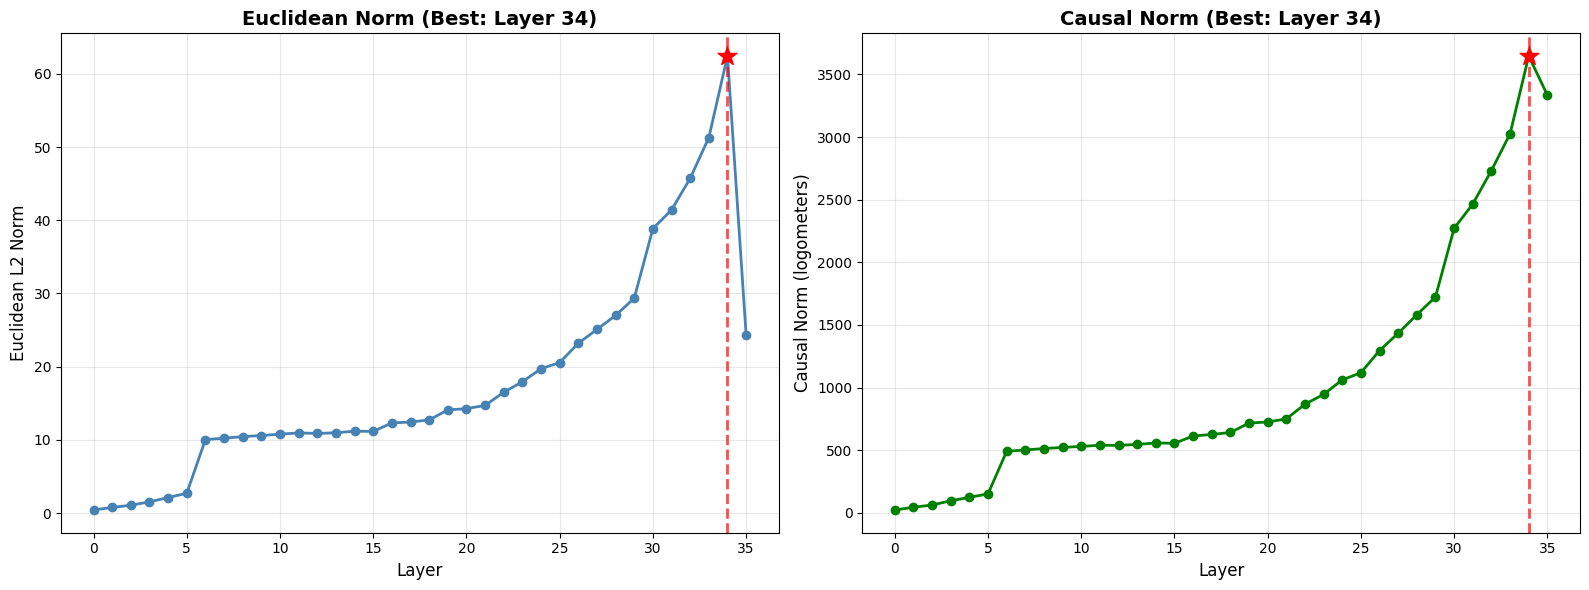

In [22]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

layers = np.arange(n_layers)
euc_norms = euclidean_norms.numpy()
cau_norms = causal_norms.numpy()

# Euclidean norms
ax1.plot(layers, euc_norms, 'o-', linewidth=2, markersize=6, color='steelblue', label='Euclidean norm')
ax1.axvline(best_layer_euclidean, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.scatter([best_layer_euclidean], [euc_norms[best_layer_euclidean]], color='red', s=200, zorder=5, marker='*')
ax1.set_xlabel('Layer', fontsize=12)
ax1.set_ylabel('Euclidean L2 Norm', fontsize=12)
ax1.set_title(f'Euclidean Norm (Best: Layer {best_layer_euclidean})', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Causal norms
ax2.plot(layers, cau_norms, 'o-', linewidth=2, markersize=6, color='green', label='Causal norm')
ax2.axvline(best_layer_causal, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.scatter([best_layer_causal], [cau_norms[best_layer_causal]], color='red', s=200, zorder=5, marker='*')
ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Causal Norm (logometers)', fontsize=12)
ax2.set_title(f'Causal Norm (Best: Layer {best_layer_causal})', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Correlation Analysis

How correlated are the two metrics across layers?

Correlation between Euclidean and Causal norms:
  Pearson r:  0.9398 (p=2.00e-17)
  Spearman ρ: 0.9928 (p=6.44e-33)


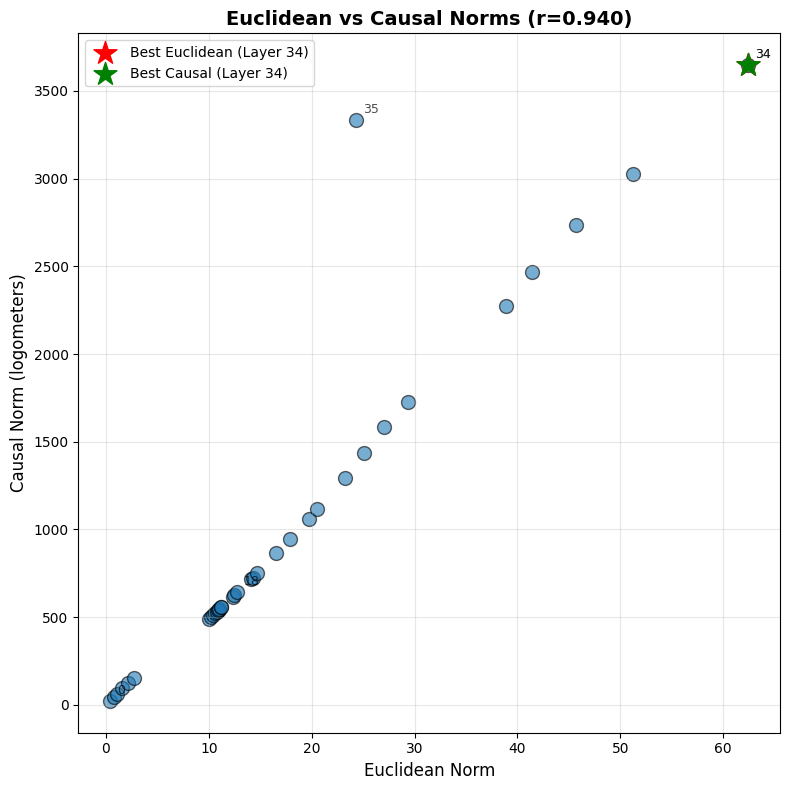


✓ Strong correlation: metrics largely agree on layer importance


In [23]:
from scipy.stats import pearsonr, spearmanr

# Compute correlations
pearson_r, pearson_p = pearsonr(euclidean_norms.numpy(), causal_norms.numpy())
spearman_r, spearman_p = spearmanr(euclidean_norms.numpy(), causal_norms.numpy())

print(f"Correlation between Euclidean and Causal norms:")
print(f"  Pearson r:  {pearson_r:.4f} (p={pearson_p:.2e})")
print(f"  Spearman ρ: {spearman_r:.4f} (p={spearman_p:.2e})")

# Scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(euclidean_norms.numpy(), causal_norms.numpy(), s=100, alpha=0.6, edgecolor='black')

# Highlight best layers
ax.scatter([euclidean_norms[best_layer_euclidean]], [causal_norms[best_layer_euclidean]], 
           s=300, color='red', marker='*', zorder=5, label=f'Best Euclidean (Layer {best_layer_euclidean})')
ax.scatter([euclidean_norms[best_layer_causal]], [causal_norms[best_layer_causal]], 
           s=300, color='green', marker='*', zorder=5, label=f'Best Causal (Layer {best_layer_causal})')

# Annotate a few layers
for layer_idx in [0, n_layers//2, n_layers-1, best_layer_euclidean, best_layer_causal]:
    ax.annotate(f'{layer_idx}', 
                xy=(euclidean_norms[layer_idx], causal_norms[layer_idx]),
                xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.7)

ax.set_xlabel('Euclidean Norm', fontsize=12)
ax.set_ylabel('Causal Norm (logometers)', fontsize=12)
ax.set_title(f'Euclidean vs Causal Norms (r={pearson_r:.3f})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if pearson_r > 0.9:
    print(f"\n✓ Strong correlation: metrics largely agree on layer importance")
elif pearson_r > 0.7:
    print(f"\n~ Moderate correlation: metrics show similar but not identical patterns")
else:
    print(f"\n⚠ Weak correlation: causal metric reveals different structure than Euclidean")

## Save Vectors with Both Metrics

In [24]:
# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Prepare output
output = {
    'vectors': steering_vectors,  # [n_layers, hidden_dim], float32
    'euclidean_norms': euclidean_norms,  # [n_layers]
    'causal_norms': causal_norms,        # [n_layers]
    'best_layer_euclidean': best_layer_euclidean,  # int
    'best_layer_causal': best_layer_causal,        # int
    'metadata': {
        'model': MODEL_NAME,
        'dataset': DATASET_NAME,
        'dataset_path': DATASET_PATH,
        'n_pairs': len(pairs),
        'max_seq_length': MAX_SEQ_LENGTH,
        'n_layers': n_layers,
        'hidden_dim': hidden_dim,
        'metric_tensor_path': METRIC_TENSOR_PATH,
        'extraction_date': datetime.now().isoformat(),
        'pearson_correlation': float(pearson_r),
        'spearman_correlation': float(spearman_r),
    }
}

# Save
output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)
torch.save(output, output_path)

print(f"✓ Saved vectors to {output_path}")
print(f"\nFile contents:")
print(f"  vectors: {steering_vectors.shape} {steering_vectors.dtype}")
print(f"  euclidean_norms: {euclidean_norms.shape}")
print(f"  causal_norms: {causal_norms.shape}")
print(f"  best_layer_euclidean: {best_layer_euclidean}")
print(f"  best_layer_causal: {best_layer_causal}")
print(f"  metadata: {len(output['metadata'])} fields")

# Compute file size
file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
print(f"\nFile size: {file_size_mb:.2f} MB")

✓ Saved vectors to ../data/vectors/complexity_wikipedia_causal.pt

File contents:
  vectors: torch.Size([36, 2560]) torch.float32
  euclidean_norms: torch.Size([36])
  causal_norms: torch.Size([36])
  best_layer_euclidean: 34
  best_layer_causal: 34
  metadata: 11 fields

File size: 0.35 MB


## Summary

Vector extraction complete using **causal metric** for layer ranking! 🎉

**Key findings:**
- Euclidean best layer: {best_layer_euclidean}
- Causal best layer: {best_layer_causal}
- Correlation: {pearson_r:.3f}

**Next steps:**
1. Test steering effectiveness with both layers
2. Compare perplexity and output quality
3. Determine if causal norm predicts better steering

The causal metric may reveal semantically potent directions that Euclidean magnitude misses!